In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
import pandas as pd
import numpy as np
import helper
from scipy.signal import savgol_filter
import statsmodels.formula.api as smf

# Head-on scenario

## Preparing the data

In [2]:
def get_df_transformed(pp_ids, scenario): #scenario = 'crossing' or 'fronting'
    
    df_plot= None
    appearances = ['sub', 'dom']
    columns_to_save = ["pp_id", "trial", "time", "x_human", "z_human", "x_spot", "z_spot", "distance", "Appearance"]
    
    for appearance in appearances:
        trials = helper.get_trial_list(scenario, appearance)

        for pp_id in pp_ids:
            path_Human = './traj_data/id_' + pp_id + '/Human'
            path_Spot = './traj_data/id_' + pp_id + '/Spot'

            for i in trials[int(pp_id)-1]:
                df_Human = pd.read_csv(path_Human + "/" + pp_id + "_"+ str(i) + ".csv", header = 0, names=["x_human", "z_human", "time"])
                df_Spot = pd.read_csv(path_Spot +  "/" + pp_id + "_"+ str(i) + ".csv", header = 0, names=["x_spot", "z_spot", "time"])
                
                # Check if the length of the dataframe matchs
                if not df_Human.size == df_Spot.size: 
                    print("Warning: Time stamp does not match!!!", pp_id, i)
                    break 

                # Concatenate to one dataframe
                df = pd.concat([df_Human.loc[:, :"z_human"], df_Spot], axis=1)
                # print("--- ", pp_id, i , " ---")
                
                # Calculate distance between two objects and append to list
                df['distance'] = np.sqrt((df['x_human']-df['x_spot'])**2 + (df['z_human']-df['z_spot'])**2)

                # Add some columns that can be useful later 
                df['trial'] = i
                df['pp_id'] = int(pp_id)
                if appearance =='sub':
                    df['Appearance'] = 'Submissive'
                if appearance == 'dom':
                    df['Appearance'] = 'Dominant'

                df_plot = pd.concat([df_plot, df.loc[:200, columns_to_save]], axis = 0)
    
    return df_plot

Put all the distance data generated above to a single dataframe for easier plotting

In [3]:
head_on_dynamics = get_df_transformed(pp_ids = ["%02d" % x for x in range(1, 22)], scenario='fronting')

In [4]:
head_on_dynamics

,pp_id,trial,time,x_human,z_human,x_spot,z_spot,distance,Appearance
0,1,2,0.0,6.746080,0.335182,0.404707,0.130609,6.344672,Submissive
1,1,2,0.1,6.746746,0.335715,0.429212,0.137520,6.320642,Submissive
2,1,2,0.2,6.746920,0.336820,0.466214,0.153150,6.283391,Submissive
3,1,2,0.3,6.746506,0.339036,0.500064,0.161931,6.248953,Submissive
4,1,2,0.4,6.743226,0.349048,0.532130,0.167215,6.213757,Submissive
...,...,...,...,...,...,...,...,...,...
160,21,15,16.0,-0.025264,-0.054138,6.269584,-0.107614,6.295075,Dominant
161,21,15,16.1,-0.025264,-0.054138,6.269584,-0.107614,6.295075,Dominant
162,21,15,16.2,-0.025264,-0.054138,6.269584,-0.107614,6.295075,Dominant
163,21,15,16.3,-0.025264,-0.054138,6.269584,-0.107614,6.295075,Dominant


Now let's smooth the data to get nicer trajectories

In [5]:
apply_filter = lambda traj: savgol_filter(traj, window_length=21, polyorder=2, axis=0)
groupby_cols = ["pp_id", "trial"]
cols_to_smooth = ["x_human", "z_human", "x_spot", "z_spot", "distance"]
head_on_dynamics.loc[:, cols_to_smooth] = (head_on_dynamics.loc[:, groupby_cols + cols_to_smooth].groupby(groupby_cols).transform(apply_filter))

participants = pd.read_csv("data/processed/participants.csv", index_col="Participant")
head_on_dynamics = head_on_dynamics.rename(columns={"pp_id": "Participant"})
head_on_dynamics = head_on_dynamics.join(participants["Experience"], on="Participant", how="left")

In [6]:
head_on_dynamics

,Participant,trial,time,x_human,z_human,x_spot,z_spot,distance,Appearance,Experience
0,1,2,0.0,6.729254,0.310807,0.381745,0.135653,6.349832,Submissive,In-person
1,1,2,0.1,6.744618,0.329546,0.420596,0.142910,6.326750,Submissive,In-person
2,1,2,0.2,6.754517,0.346026,0.460796,0.149623,6.296800,Submissive,In-person
3,1,2,0.3,6.758951,0.360246,0.502345,0.155792,6.259983,Submissive,In-person
4,1,2,0.4,6.757919,0.372206,0.545244,0.161417,6.216298,Submissive,In-person
...,...,...,...,...,...,...,...,...,...,...
160,21,15,16.0,-0.024746,-0.054019,6.265596,-0.108157,6.290577,Dominant,In-person
161,21,15,16.1,-0.025079,-0.054073,6.284160,-0.106545,6.309453,Dominant,In-person
162,21,15,16.2,-0.025500,-0.054145,6.300586,-0.105088,6.326280,Dominant,In-person
163,21,15,16.3,-0.026009,-0.054238,6.314872,-0.103785,6.341059,Dominant,In-person


In [7]:
head_on_dynamics.to_csv("./data/processed/head_on_dynamics_processed.csv", index=False)

## Reading the processed data

In [8]:
participants = pd.read_csv("data/processed/participants.csv", index_col="Participant")
head_on_dynamics = pd.read_csv("data/processed/head_on_dynamics_processed.csv")

In [9]:
participants

,Rating,Sex,Age,Familiarity,Attitude,Experience,attitude_q
Participant,,,,,,,
1,3.40625,M,26,5,4,In-person,Positive
2,2.96875,M,27,3,4,Videos,Positive
3,3.03125,M,26,4,4,In-person,Positive
4,2.84375,M,26,4,1,In-person,Negative
5,3.46875,M,30,4,4,In-person,Positive
6,3.50000,M,23,3,5,Videos,Positive
7,4.09375,M,34,4,4,In-person,Positive
8,3.71875,M,27,5,5,In-person,Positive
9,3.15625,F,26,3,3,Videos,Negative


In [10]:
head_on_dynamics

,Participant,trial,time,x_human,z_human,x_spot,z_spot,distance,Appearance,Experience
0,1,2,0.0,6.729254,0.310807,0.381745,0.135653,6.349832,Submissive,In-person
1,1,2,0.1,6.744618,0.329546,0.420596,0.142910,6.326750,Submissive,In-person
2,1,2,0.2,6.754517,0.346026,0.460796,0.149623,6.296800,Submissive,In-person
3,1,2,0.3,6.758951,0.360246,0.502345,0.155792,6.259983,Submissive,In-person
4,1,2,0.4,6.757919,0.372206,0.545244,0.161417,6.216298,Submissive,In-person
...,...,...,...,...,...,...,...,...,...,...
57539,21,15,16.0,-0.024746,-0.054019,6.265596,-0.108157,6.290577,Dominant,In-person
57540,21,15,16.1,-0.025079,-0.054073,6.284160,-0.106545,6.309453,Dominant,In-person
57541,21,15,16.2,-0.025500,-0.054145,6.300586,-0.105088,6.326280,Dominant,In-person
57542,21,15,16.3,-0.026009,-0.054238,6.314872,-0.103785,6.341059,Dominant,In-person


## Walking trajectories

One trajectory

In [11]:
traj = head_on_dynamics[(head_on_dynamics.Participant==1) & (head_on_dynamics.trial==14)]

In [12]:
traj

,Participant,trial,time,x_human,z_human,x_spot,z_spot,distance,Appearance,Experience
29211,1,14,0.0,6.747256,0.221597,0.336244,0.124086,6.411807,Dominant,In-person
29212,1,14,0.1,6.749667,0.219802,0.310672,0.124821,6.439722,Dominant,In-person
29213,1,14,0.2,6.751720,0.218758,0.290059,0.125652,6.462335,Dominant,In-person
29214,1,14,0.3,6.753415,0.218462,0.274403,0.126580,6.479647,Dominant,In-person
29215,1,14,0.4,6.754750,0.218917,0.263706,0.127605,6.491657,Dominant,In-person
...,...,...,...,...,...,...,...,...,...,...
29402,1,14,19.1,-0.056391,-0.004252,6.023499,0.186397,6.082950,Dominant,In-person
29403,1,14,19.2,-0.057249,-0.003880,6.005485,0.177663,6.065522,Dominant,In-person
29404,1,14,19.3,-0.058189,-0.003467,5.985682,0.168022,6.046358,Dominant,In-person
29405,1,14,19.4,-0.059210,-0.003014,5.964091,0.157475,6.025459,Dominant,In-person


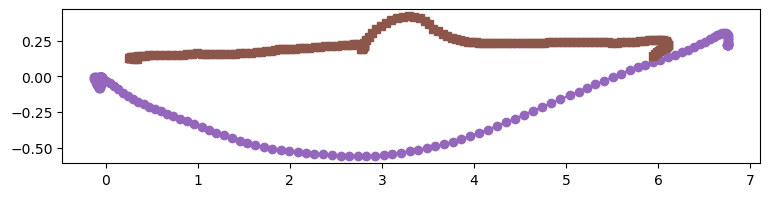

In [13]:
fig, ax = plt.subplots()
ax.plot(traj.x_human, traj.z_human, color="C4", marker="o", label="Human")
ax.plot(traj.x_spot, traj.z_spot, color="C5", marker="s", label="Robot")
fig.set_figheight(2)
fig.set_figwidth(9)

All trajectories of one participant

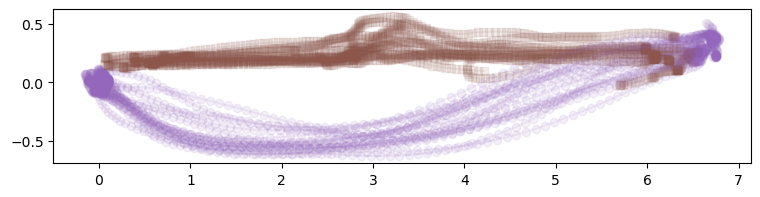

In [27]:
fig, ax = plt.subplots()
head_on_dynamics_p_1 = head_on_dynamics[head_on_dynamics.Participant==1]

for trial, traj in head_on_dynamics_p_1.groupby("trial"):
    ax.plot(traj.x_human, traj.z_human, color="C4", marker="o", label="Human", alpha=0.1)
    ax.plot(traj.x_spot, traj.z_spot, color="C5", marker="s", label="Robot", alpha=0.1)
    
fig.set_figheight(2)
fig.set_figwidth(9)

All trajectories of all participants

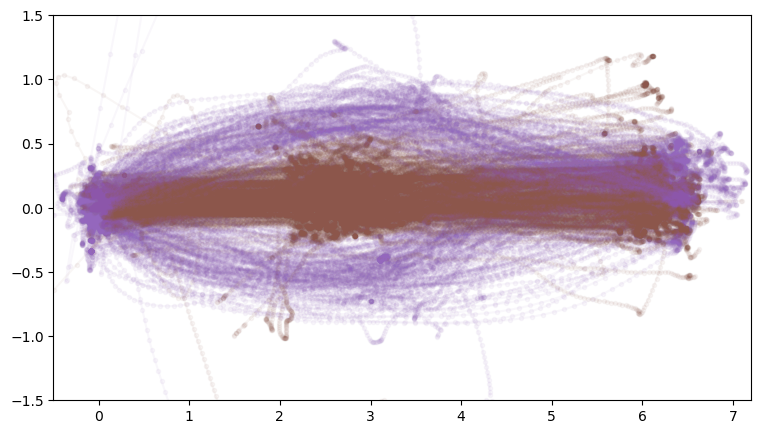

In [33]:
fig, ax = plt.subplots() 
for traj_name, traj in head_on_dynamics.groupby(["Participant", "trial"]):
    ax.plot(traj.x_human, traj.z_human, color="C4", marker=".", label="Human", alpha=0.05)
    ax.plot(traj.x_spot, traj.z_spot, color="C5", marker=".", label="Robot", alpha=0.05)
    ax.set_xlim([-0.5, 7.2])
    ax.set_ylim([-1.5, 1.5])
    
fig.set_figheight(5)
fig.set_figwidth(9)

Note: The solid point on the left top is trial 1 of participant 3. Spot's tracker was not working. 
The other one, I didn't find which trial. 

## TODO: transform the coordinate frame such that all trajectories are aligned

## Distance: Dominant vs submissive

<Axes: xlabel='time', ylabel='distance'>

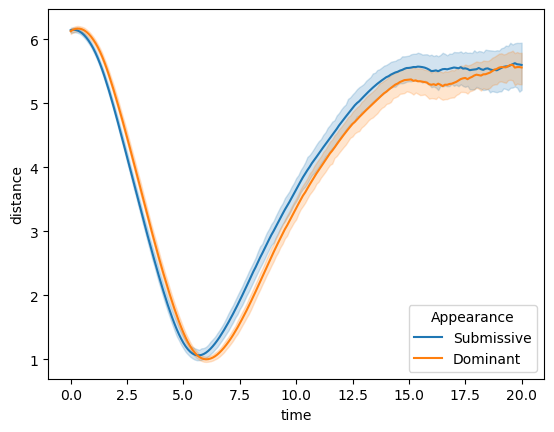

In [16]:
sns.lineplot(data=head_on_dynamics, x='time', y='distance', hue="Appearance")

<Axes: xlabel='time', ylabel='distance'>

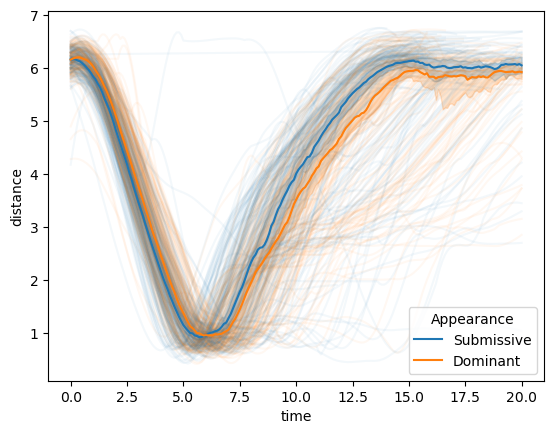

In [17]:
fig, ax = plt.subplots()
for name, traj in head_on_dynamics.groupby(["Participant", "trial"]):
    appearance = traj.Appearance.iloc[0]
    ax.plot(traj.time, traj.distance, color="C0" if appearance=="Submissive" else "C1", alpha=0.05)
sns.lineplot(data=head_on_dynamics, x='time', y='distance', hue="Appearance", estimator=np.median, ax=ax)

## Distance: With and without in-person experience

AttributeError: 'DataFrame' object has no attribute 'distance_s'

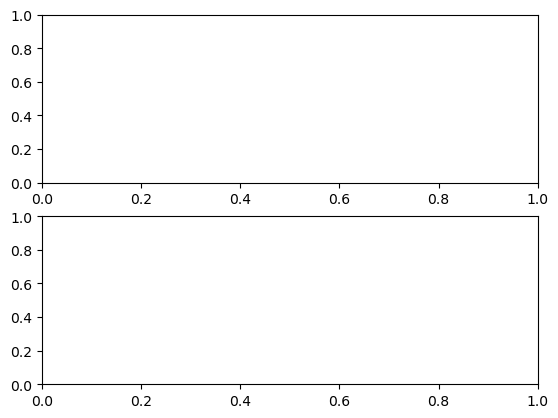

In [18]:
fig, axes = plt.subplots(2, 1)
for ax, experience in zip(axes, ["In-person", "Videos"]):
    for name, traj in head_on_dynamics[head_on_dynamics.Experience==experience].groupby(["Participant", "trial"]):
        appearance = traj.Appearance.iloc[0]
        ax.plot(traj.time, traj.distance_s, color="C0" if appearance=="Submissive" else "C1", alpha=0.05)
    sns.lineplot(data=head_on_dynamics[head_on_dynamics.Experience==experience], 
                 x="time", y="distance_s", hue="Appearance", estimator=np.median, 
                 palette=["C0", "C1"], ax=ax)
    ax.set_title("Previous experience: %s" % (experience))
    
plt.tight_layout()
plt.savefig("head_on_distance_over_time_by_experience.png", dpi=300, bbox_inches="tight")

In [ ]:
fig, axes = plt.subplots(2, 1)
for ax, appearance in zip(axes, ["Submissive", "Dominant"]):
    for name, traj in head_on_dynamics[head_on_dynamics.Appearance==appearance].groupby(["Participant", "trial"]):
        # appearance = traj.Appearance.iloc[0]
        experience = traj.Experience.iloc[0]
        ax.plot(traj.time, traj.distance_s, color="C2" if experience=="In-person" else "C3", alpha=0.05)
    sns.lineplot(data=head_on_dynamics[head_on_dynamics.Appearance==appearance], 
                 x="time", y="distance_s", hue="Experience", estimator=np.median, 
                 palette=["C2", "C3"], ax=ax)
    ax.set_title("Robot appearance: %s" % (appearance))
    
plt.tight_layout()
plt.savefig("head_on_distance_over_time_by_appearance.png", dpi=300, bbox_inches="tight")

## Distance: Differences in trials over time

### For both appearances

In [ ]:
sns.lineplot(data=head_on_dynamics[(head_on_dynamics.trial.isin([1, 17]))], 
             x="time", y="distance", label="early")
sns.lineplot(data=head_on_dynamics[(head_on_dynamics.trial.isin([13, 14, 15, 16, 29, 30, 31, 32]))], 
             x="time", y="distance", label="late")

### For submissive

In [ ]:
sns.lineplot(data=head_on_dynamics[(head_on_dynamics.trial.isin([1, 17])) & (head_on_dynamics["Appearance"]=="Submissive")], 
             x="time", y="distance_s", label="early")
sns.lineplot(data=head_on_dynamics[(head_on_dynamics.trial.isin([13, 14, 15, 16, 29, 30, 31, 32]))& (head_on_dynamics["Appearance"]=="Submissive")], 
             x="time", y="distance_s", label="late")

### For dominant

In [ ]:
sns.lineplot(data=head_on_dynamics[(head_on_dynamics.trial.isin([1, 17])) & (head_on_dynamics["Appearance"]=="Dominant")], 
             x="time", y="distance_s", label="early")
sns.lineplot(data=head_on_dynamics[(head_on_dynamics.trial.isin([13, 14, 15, 16, 29, 30, 31, 32]))& (head_on_dynamics["Appearance"]=="Dominant")], 
             x="time", y="distance_s", label="late")

## Metrics: Getting metrics for each trajectory

In [ ]:
def get_min_distance(traj):
    idx_min = traj.distance_s.idxmin()
    return pd.Series({"idx_min": idx_min,
                      "t_min": traj.iloc[idx_min].time, 
                      "d_min": traj.iloc[idx_min].distance_s}) 

In [ ]:
traj = head_on_dynamics[(head_on_dynamics.Participant==1) & (head_on_dynamics.trial==2)]
fig, ax = plt.subplots(1)
ax.plot(traj.time, traj.distance_s)
traj_measures = get_min_distance(traj)
ax.plot(traj_measures.t_min, traj_measures.d_min, label="Minimum distance", color="C2", marker="o")
ax.axvline(traj_measures.t_min, ymin=0, ymax=0.2, color="grey", ls="--")
plt.legend()

In [ ]:
distance_metrics = (head_on_dynamics.groupby(["Participant", "trial"])
                    .apply(get_min_distance)
                    .join(head_on_dynamics.groupby(["Participant", "trial"]).first()[["Appearance", "Experience"]])
                    .reset_index())

In [ ]:
distance_metrics

## Metrics: Analyses

### Time of resolving the conflict

Let's look at the average time of resolving the conflict (e.g. time at which distance between the human and the spot was minimal)

In [ ]:
distance_metrics[distance_metrics.Appearance=="Dominant"].t_min.mean(), distance_metrics[distance_metrics.Appearance=="Submissive"].t_min.mean()

It seems that in interactions with the submissive robot, participants were slightly faster reaching it (difference of 230ms)

In [ ]:
ax = sns.pointplot(data=distance_metrics, x="Appearance", y="t_min", hue="Participant")
plt.setp(ax.collections, alpha=.3, zorder=1) #for the markers
plt.setp(ax.lines, alpha=.3, zorder=1)
sns.pointplot(data=distance_metrics, x="Appearance", y="t_min", color="black", ax=ax)

In [ ]:
ax = sns.pointplot(data=distance_metrics, x="Experience", y="t_min", hue="Appearance", hue_order=["Submissive", "Dominant"], dodge=True)
ax.set_ylabel("Time when human and robot pass each other")

But what if we take into account the individual differences in baseline t_min/speed?
 - Mixed-effects model estimates the difference to be smaller (184ms difference between dominant and submissive)
  - It is not statistically significant (p=0.14)

In [ ]:
mdf_t = smf.mixedlm("t_min ~ Appearance*Experience", distance_metrics.reset_index(), groups=distance_metrics.reset_index()["Participant"]).fit()
print(mdf_t.summary())

### Safety margin

The safety margins adopted by participants appear very similar (73-74cm)

In [ ]:
distance_metrics[distance_metrics.Appearance=="Dominant"].d_min.mean(), distance_metrics[distance_metrics.Appearance=="Submissive"].d_min.mean()

In [ ]:
distance_metrics.d_min.hist()

In [ ]:
ax = sns.pointplot(data=distance_metrics, x="Appearance", y="d_min", hue="Participant")
plt.setp(ax.collections, alpha=.3, zorder=1) #for the markers
plt.setp(ax.lines, alpha=.3, zorder=1)
sns.pointplot(data=distance_metrics, x="Appearance", y="d_min", color="black", ax=ax)

Here too, there is no evidence for a significant difference between dominant and submissive Spot

In [ ]:
ax = sns.pointplot(data=distance_metrics, x="Experience", y="d_min", hue="Appearance", hue_order=["Submissive", "Dominant"], dodge=True)
ax.set_ylabel("Safety margin, m")
ax.set_ylim((0.5, 1.0))

In [ ]:
mdf_d = smf.mixedlm("d_min ~ Appearance*Experience", distance_metrics.reset_index(), groups=distance_metrics.reset_index()["Participant"]).fit()
print(mdf_d.summary())

In [ ]:
mdf_d = smf.mixedlm("d_min ~ Appearance", distance_metrics[distance_metrics.Experience=="Videos"].reset_index(), groups=distance_metrics[distance_metrics.Experience=="Videos"].reset_index()["Participant"]).fit()
print(mdf_d.summary())

### Safety margin by trial number

In [ ]:
distance_metrics["Early/Late"] = None
distance_metrics.loc[(distance_metrics.trial==1) | (distance_metrics.trial==17), ["Early/Late"]] = "Early"
distance_metrics.loc[(distance_metrics.trial==16) | (distance_metrics.trial==32), ["Early/Late"]] = "Late"

In [ ]:
sns.pointplot(data=distance_metrics, x="Appearance", y="d_min", hue="Early/Late", dodge=True)

# Crossing scenario

In [ ]:
df_crossing = get_df_transformed(pp_ids= ["%02d" % x for x in range(1, 22)], scenario = 'crossing')

### Preprocess the data

In [ ]:
df_crossing

In [ ]:
apply_filter = lambda traj: savgol_filter(traj, window_length=21, polyorder=2, axis=0)
groupby_cols = ["pp_id", "trial"]
cols_to_smooth = ["x_human", "z_human", "x_spot", "z_spot"]
df_crossing.loc[:, ["x_human", "z_human", "x_spot", "z_spot"]] = (df_crossing.loc[:, groupby_cols + cols_to_smooth].groupby(groupby_cols).transform(apply_filter))

mean_positions = df_crossing.loc[df_crossing["time"] == 0.0, ["x_human", "z_human", "x_spot", "z_spot"]].mean()
df_crossing.loc[:, "distance_to_crossing_human"] = np.sqrt((df_crossing.x_human - mean_positions.x_human)**2 + (df_crossing.z_human - mean_positions.z_spot)**2)
df_crossing.loc[:, "distance_to_crossing_robot"] = np.sqrt((df_crossing.x_spot - mean_positions.x_human)**2 + (df_crossing.z_spot - mean_positions.z_spot)**2)

## Starting and final positions

In [ ]:
starting_positions = df_crossing.groupby(["pp_id", "trial"]).first()
final_positions = df_crossing.groupby(["pp_id", "trial"]).last()

In [ ]:
mean_positions

In [ ]:
fig, ax = plt.subplots()
ax.scatter(starting_positions.x_human, starting_positions.z_human, color="C0", marker="o", label="human start")
ax.scatter(final_positions.x_human, final_positions.z_human, color="C0", marker="x", label="human final")
ax.scatter(starting_positions.x_spot, starting_positions.z_spot, color="C1", marker="o", label="robot start")
ax.scatter(final_positions.x_spot, final_positions.z_spot, color="C1", marker="x", label="robot final")
ax.plot(mean_positions.x_human, mean_positions.z_human, color="k", ls="", marker="s", ms=10, label="average starting points")
ax.plot(mean_positions.x_spot, mean_positions.z_spot, color="k", marker="s", ms=10)
ax.legend()

Let's assume HCP(Hypothetical crossing point): (x, z) = (3.28, 0). In this transformed coordinate, Spot always start from 
approximately (0, 0).

## Illustrating one crossing trial

In [ ]:
trial = df_crossing[(df_crossing.pp_id==1) & (df_crossing.trial==17)]

In [ ]:
trial

In [ ]:
fig, ax = plt.subplots()
ax.plot(trial.x_human[0], trial.z_human[0], color="k", ls="", marker="o", ms=10, label="human start")
ax.scatter(trial.x_human, trial.z_human, c=cm.viridis(trial.time/trial.time.max()), marker="o", label="human")
ax.plot(trial.x_spot[0], trial.z_spot[0], color="k", ls="", marker="s", ms=10, label="robot start")
ax.scatter(trial.x_spot, trial.z_spot, c=cm.plasma(trial.time/trial.time.max()), marker="s", label="robot")
ax.legend()

## Animation

# Trajectories
### Note: Coordinate of participants 11~13 is not aligned to the axis :( I am still figuring out why. 

Animations are better saved in a gif file, it's tricky to render them reliably in a Jupyter notebook. Saving does take some time though

In [ ]:
# set dt to 50ms to get 2x speed-up in the animation
# to keep the original speed, set dt to 100 ms
dt = 50 #ms
fig, ax = plt.subplots()

traj_human = ax.scatter(trial.x_human[0], trial.z_human[0], c="k", marker="o", label="human")
traj_robot = ax.scatter(trial.x_spot[0], trial.z_spot[0], c="k", marker="s", label="robot")

ax.set(xlim=[0, 7], ylim=[-3.5, 3.5])
ax.legend()

def update(frame):
    data_human = np.stack([trial.x_human[:frame], trial.z_human[:frame]]).T
    data_robot = np.stack([trial.x_spot[:frame], trial.z_spot[:frame]]).T
    traj_human.set_offsets(data_human)
    traj_robot.set_offsets(data_robot)
    return (traj_human, traj_robot)

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(trial), interval=dt)
ani.save("crossing_trial.gif", writer="pillow", fps=1000/dt)

## Getting the metrics

In [ ]:
plt.plot(trial.time, trial.distance_to_crossing_human, label="human")
plt.plot(trial.time, trial.distance_to_crossing_robot, label="robot")

In [ ]:
def get_t_crossing(traj):
    idx_min_human = traj.distance_to_crossing_human.idxmin()
    idx_min_robot = traj.distance_to_crossing_robot.idxmin()
    return pd.Series({"idx_min_human": idx_min_human,
                      "idx_min_robot": idx_min_robot,
                      "t_crossing_human": traj.iloc[idx_min_human].time, 
                      "t_crossing_robot": traj.iloc[idx_min_robot].time})

crossing_metrics = (df_crossing.groupby(["pp_id", "trial"])
                    .apply(get_t_crossing)
                    .join(df_crossing.groupby(["pp_id", "trial"]).first()["appearance"])
                    .reset_index())

In [ ]:
crossing_metrics["is_human_first"] = crossing_metrics["t_crossing_human"] < crossing_metrics["t_crossing_robot"]
crossing_metrics["crossed_first"] = "robot"
crossing_metrics.loc[crossing_metrics.is_human_first, ["crossed_first"]] = "human"

In [ ]:
crossing_metrics

## Who crossed first?

In [ ]:
fig, ax = plt.subplots()
g = sns.countplot(data=crossing_metrics, x="crossed_first", hue="appearance", ax=ax)
ax.set_xlabel("Who went first")
g.legend().set_title("Robot appearance")
# g.legend.set_title("TTA")

In [ ]:
fig, ax = plt.subplots()
sns.pointplot(data=crossing_metrics, y="is_human_first", x="appearance", hue="pp_id", ax=ax)
ax.set_ylim((-0.1,1.1))
ax.set_ylabel("% human went first")

## Crossing trajectories

In [ ]:
fig, ax = plt.subplots()
for name, traj in df_crossing.groupby(["pp_id", "trial"]):
    # appearance = traj.Appearance.iloc[0]
    ax.plot(traj.time, traj.distance_to_crossing_human, color="C0", alpha=0.05)
    ax.plot(traj.time, traj.distance_to_crossing_robot, color="C1", alpha=0.05)
ax.set_xlim((0, 20))
sns.lineplot(data=df_crossing, x='time', y='distance_to_crossing_human', color="C0", estimator=np.median, ax=ax)
sns.lineplot(data=df_crossing, x='time', y='distance_to_crossing_robot', color="C1", estimator=np.median, ax=ax)

In [ ]:
def get_trajectory_df(pp_ids, apparance, position_of, scenario):
    
    df_plot= None
    
    #Iterate over participants
    for pp_id in pp_ids:
        path = './traj_data/id_' + pp_id + '/' + position_of
       # path_Spot = './traj_data/id_' + pp_id + '/Spot'

        trials = helper.get_trial_list(scenario, apparance)
        
        # Add each trial to one dataframe
        for i in trials[int(pp_id)-1]:
            df = pd.read_csv(path + "/" + pp_id + "_"+ str(i) + ".csv")
            
            # Add some columns that can be useful later 
            df['trial'] = str(i)
            df['pp_id'] = pp_id
            # print(df['z'])
            df['z'] = df['z'] - df.loc[0]['z'] # To adjust noise in the start 
            
            df_plot = pd.concat([df_plot, df.loc[:200]], axis = 0)
            
    return df_plot

In [ ]:
## First, plot all the trajectory points for Spot (dominant)

df_traj_Spot = get_trajectory_df(pp_ids = ["%02d" % x for x in range(1, 22)], apparance = 'dom', position_of = 'Spot', scenario = 'fronting');
sns.scatterplot(data = df_traj_Spot.loc[: , ['x', 'z', 'time']], x = 'x', y = 'z', hue = 'time')

In [ ]:
# Human, dominant
df_traj_Human = get_trajectory_df(pp_ids =  ["%02d" % x for x in range(1, 12)], apparance = 'dom', position_of = 'Human', scenario = 'fronting');
sns.scatterplot(data = df_traj_Human.loc[: , ['x', 'z', 'time']], x = 'x', y = 'z', hue = 'time' )

In [ ]:
#sns.lineplot(data = df_traj_Human.loc[:, ['x', 'z','time']], x = 'x', y = 'z')
# Line plot is ugly here

In [ ]:
# Next idea
# Groupby participants -> draw 21 trajectories??
# (This part is not done.)

df_traj_Spot_pp = df_traj_Spot.groupby(['pp_id']).mean()
sns.scatterplot(data = df_traj_Spot.loc[: , ['x', 'z', 'time']], x = 'x', y = 'z', hue = 'time')